# k近邻 (k-nearest neighbor, k-NN)
k近邻是一种非常简单的监督学习模型，既可以用于分类问题，也可以用于回归问题。  
  
模型的工作原理：基于某种**距离度量**找到离预测样本最近的k个训练样本，然后用这k个训练样本的信息来进行预测。对于分类问题，一般使用**多数表决法**，即将这k个训练样本中出现最多的类别作为预测样本的类别；对于回归问题，一般使用**均值法**，即将这k个训练样本的真实值的均值作为预测样本的预测值。 
  
（后面我们只讨论分类问题）

## 1.模型定义
k-NN模型实际上对应于对训练集的特征空间的一个划分，将整个特征空间划分为一些子空间。模型由以下三个要素确定：
- k值选择
- 距离度量
- 分类决策（比如多数表决）

k-NN算法并没有训练过程，当训练集、k值、距离度量以及分类决策都确定后，对于要预测的新数据来说，它的类别也唯一确定了。

## 2.KNN三要素

### 2.1 k值选择
![图片来自Wiki](https://upload.wikimedia.org/wikipedia/commons/thumb/e/e7/KnnClassification.svg/220px-KnnClassification.svg.png)
k值的大小对模型的预测结果有很大的影响。如上图所示，绿色的圆形是要进行分类的新样本，当k=3时，距离其最近的3个样本分别是两个三角形和一个正方形，所以根据多数表决法该新样本会划分成三角形那一类；同理，当k=5时，新样本会被划分成正方形那一类。  
  
如果选择较小的k值，相当于用较小领域中的训练样本来决定预测样本的类别，这使得模型会非常敏感，如果k=1，当最近的这个训练样本恰好是噪声时，则预测结果就会出错；  
如果选择较大的k值，相当于用较大领域中的训练样本来决定预测样本的类别，这会使得较远的（不相似的）训练样本对预测结果产生影响，如果k=N，即用到整个训练集，那么无论预测样本是什么，都会把它预测成训练集中出现最多的那一类。  
>**k值越小意味着模型越复杂，容易发生过拟合；越大意味着模型越简单，容易发现欠拟合**  

在实际中，一般采用交叉验证法来选取合适的k值。

### 2.2 距离度量
在k近邻模型中，两个样本点的距离反应了它们的相似程度。距离度量一般采用的是$L_{p}$距离。  
假设样本是n维的，则任意两个样本$x_{i}, x_{j}$的$L_{p}$距离定义为：
$$L_{p}(x_{i}, x_{j})=\big(\sum^{n}_{l=1}\big|x^{l}_{i}-x^{l}_{j}\big|^{p}\big)^{\frac{1}{p}},\quad p\geq 1$$
当p=1时，为曼哈顿距离：
$$L_{1}(x_{i}, x_{j})=\sum^{n}_{l=1}\big|x^{l}_{i}-x^{l}_{j}\big|$$
当p=2时，为欧氏距离：
$$L_{2}(x_{i}, x_{j})=\big(\sum^{n}_{l=1}\big|x^{l}_{i}-x^{l}_{j}\big|^{2}\big)^{\frac{1}{2}}$$ 
当p=∞时，是各个维度距离的最大值：
$$L_{\infty}(x_{i}, x_{j})=max\,\big|x^{l}_{i}-x^{l}_{j}\big|$$  
  
不同的距离度量所确定的最邻近的样本是不同的，在实际中，最常采用的是欧氏距离。

### 2.3 分类决策
k近邻模型最常使用的分类决策是多数表决法，即预测样本的类别由距离其最近的k个训练样本中出现频率最高的类别决定。  
  
对于某个要预测的样本，其最近的k个训练样本构成集合$N_{k}$，并且这个集合所占的区域的类别为c，那么误分类率为：
$$\frac{1}{k}\sum_{x_{i}\in N_{k}}I(y_{i}\neq c)=1-\frac{1}{k}\sum_{x_{i}\in N_{k}}I(y_{i}= c)$$
我们要最小化误分类率，就要使$\sum_{x_{i}\in N_{k}}I(y_{i}= c)$最大，即让特征空间划分后的每个子空间中的所有训练样本为同一类别，所有多数表决法等同于训练误差最小化。

## 3.算法流程
假设训练集的类别总数为$K$，要预测新样本x的类别，流程如下：
1. 根据距离度量找到训练集中与x最近的k个样本，将这k个样本构成的领域记作$N_{k}$；
2. 根据多数表决法决定x的类别y：$$y = argmax_{c_{j}}\sum_{x_{i}\in N_{k}}I(y_{i}= c_{j}),\quad j=1,2,...,K$$

当k=1时，k近邻法称为最近邻法。

## 4.Code
code time :-）  
这里依然用Iris数据集进行演示。

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from collections import Counter
%matplotlib inline

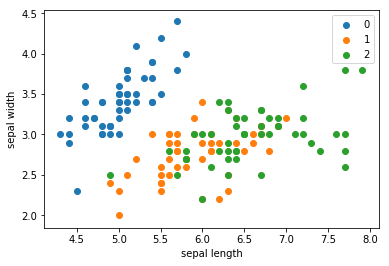

In [59]:
# 加载Iris数据集
iris = load_iris()
X = iris.data[:, :2]  # 只取前两个特征
Y = iris.target

# 可视化
plt.scatter(X[:50][:,0], X[:50][:,1], label='0')
plt.scatter(X[50:100][:, 0], X[50:100][:, 1], label='1')
plt.scatter(X[100:][:, 0], X[100:][:, 1], label='2')
plt.xlabel('sepal length')
plt.ylabel('sepal width')
plt.legend()
plt.show()

In [92]:
class KNN(object):
    def __init__(self, X, Y, k_neighbors, p=2):
        self.k_neighbors = k_neighbors
        self.p = p
        self.X = X
        self.Y = Y
        assert (k_neighbors <= X.shape[0])
        
    def get_distance(self, x):
        if self.p == 1:
            return np.sum(np.abs(self.X - x), axis=1)
        elif self.p == 2:
            return np.sqrt(np.sum(np.power(self.X - x, 2), axis=1))
        elif self.p == 'inf':
            return np.max(np.abs(self.X - x), axis=1)
    
    def predict(self, x):
        distance = self.get_distance(x)
        # 返回距离从大到小对应的索引
        indx = np.argsort(distance)
        # 最近k个样本的类别
        nearnest_k_labels = Y[indx[:self.k_neighbors]]
        # 找到出现频率最高的类别
        counts = np.bincount(nearnest_k_labels)
        result = np.argmax(counts)
        
        return result, nearnest_k_labels

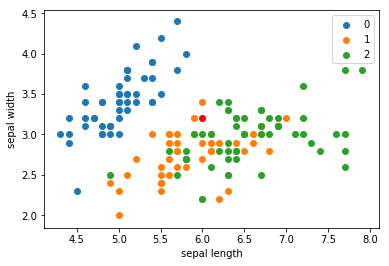

In [88]:
# 定义一个要预测的样本
test_sample = [6, 3.2]
# 可视化
plt.scatter(X[:50][:,0], X[:50][:,1], label='0')
plt.scatter(X[50:100][:, 0], X[50:100][:, 1], label='1')
plt.scatter(X[100:][:, 0], X[100:][:, 1], label='2')
plt.plot(test_sample[0], test_sample[1], 'ro')
plt.xlabel('sepal length')
plt.ylabel('sepal width')
plt.legend()
plt.show()

In [94]:
knn_model = KNN(X, Y, k_neighbors=3)
# 预测
label, nearnest_labels = knn_model.predict(test_sample)
print('最邻近的训练样本类别为：',nearnest_labels)
print('预测类别为：', label)

最邻近的训练样本类别为： [1 1 2]
预测类别为： 1
